По условию соревнования, обучающий датасет собран.

In [102]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import os # accessing directory structure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_regression
import json

from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor


from scipy.stats import boxcox
from scipy.stats import yeojohnson, uniform
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, truncnorm, randint
from pprint import pprint
import random
from catboost import CatBoostRegressor
from itertools import groupby

import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import recall_score
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.base import clone
import datetime
from datetime import datetime, timedelta
import math

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
# from feature_selector import FeatureSelector
from pprint import pprint

In [103]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [104]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [105]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [106]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [107]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction/test.csv
/kaggle/input/-autoru-041220/all_auto_ru_04_12_20_2.csv


# Setup

In [108]:
VERSION    = 15
DIR_TRAIN  = '/kaggle/input/-autoru-041220/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# # CATBOOST
# ITERATIONS = 5000
# LR         = 0.1

# Data

In [109]:
!ls ../input/

-autoru-041220	sf-dst-car-price-prediction


In [110]:
# загрузим данные обучающей и тестовой выборки
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_04_12_20_2.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

Перед объединением данных обучающей и тестовой выборки проверим чем они различаются и приведем данные к общему знаменателю

In [111]:
train.sample(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Таможня,Владение,price,vendor,super_gen,equipment_dict,model_info,model_name,start_date,hidden
31904,Лифтбек,MAZDA,0000CC,бензин,2002.0,2.0 AT (141 л.с.),5.0,2004,LIFTBACK AUTOMATIC 2.0,AUTOMATIC,...,True,NaN,275000.0,JAPANESE,"{'id': '3484060', 'name': 'I (GG)', 'ru_name':...","{'engine-proof': True, 'alloy-wheel-disks': Tr...","{'code': '6', 'name': '6', 'ru_name': '6', 'mo...",6,2020-11-21T06:34:38Z,NaN
19303,Седан,HONDA,CACECB,бензин,1998.0,2.5 AT (200 л.с.),4.0,1999,SEDAN AUTOMATIC 2.5,AUTOMATIC,...,True,"{'year': 2020, 'month': 1}",180000.0,JAPANESE,"{'id': '8295026', 'name': 'III', 'ru_name': '3...","{'electro-window-back': True, 'ptf': True, 'ai...","{'code': 'INSPIRE', 'name': 'Inspire', 'ru_nam...",Inspire,2020-11-18T08:53:54Z,NaN


In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76145 entries, 0 to 76144
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              76142 non-null  object 
 1   brand                 76145 non-null  object 
 2   color                 76145 non-null  object 
 3   fuelType              76145 non-null  object 
 4   modelDate             76142 non-null  float64
 5   name                  76142 non-null  object 
 6   numberOfDoors         76142 non-null  float64
 7   productionDate        76145 non-null  int64  
 8   vehicleConfiguration  76142 non-null  object 
 9   vehicleTransmission   76142 non-null  object 
 10  engineDisplacement    76142 non-null  object 
 11  enginePower           76142 non-null  float64
 12  description           73948 non-null  object 
 13  mileage               76145 non-null  int64  
 14  complectation_dict    76145 non-null  object 
 15  Привод             

In [113]:
train

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Таможня,Владение,price,vendor,super_gen,equipment_dict,model_info,model_name,start_date,hidden
0,Седан,AUDI,040001,бензин,1990.0,2.3 MT (133 л.с.),4.0,1992,SEDAN MECHANICAL 2.3,MECHANICAL,...,True,NaN,100000.0,EUROPEAN,"{'id': '7879464', 'name': 'IV (C4)', 'ru_name'...",{},"{'code': '100', 'name': '100', 'ru_name': '100...",100,2020-12-02T16:59:26Z,NaN
1,Седан,AUDI,040001,бензин,1990.0,2.3 MT (133 л.с.),4.0,1991,SEDAN MECHANICAL 2.3,MECHANICAL,...,True,"{'year': 2020, 'month': 8}",190000.0,EUROPEAN,"{'id': '7879464', 'name': 'IV (C4)', 'ru_name'...",{},"{'code': '100', 'name': '100', 'ru_name': '100...",100,2020-11-08T17:23:26Z,NaN
2,Седан,AUDI,97948F,бензин,1988.0,2.3 MT (136 л.с.),4.0,1989,SEDAN MECHANICAL 2.3,MECHANICAL,...,True,NaN,65000.0,EUROPEAN,"{'id': '7893785', 'name': 'III (C3) Рестайлинг...",{},"{'code': '100', 'name': '100', 'ru_name': '100...",100,2020-11-18T09:00:59Z,NaN
3,Седан,AUDI,FAFBFB,бензин,1982.0,2.0 MT (112 л.с.),4.0,1987,SEDAN MECHANICAL 2.0,MECHANICAL,...,True,NaN,55000.0,EUROPEAN,"{'id': '7892647', 'name': 'III (C3)', 'ru_name...",{},"{'code': '100', 'name': '100', 'ru_name': '100...",100,2020-11-28T21:17:36Z,NaN
4,Седан,AUDI,0000CC,бензин,1988.0,2.0 MT (115 л.с.),4.0,1989,SEDAN MECHANICAL 2.0,MECHANICAL,...,True,NaN,90000.0,EUROPEAN,"{'id': '7893785', 'name': 'III (C3) Рестайлинг...",{},"{'code': '100', 'name': '100', 'ru_name': '100...",100,2020-11-15T10:23:16Z,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76140,Минивэн,SSANG_YONG,040001,дизель,2013.0,2.0d AT (149 л.с.) 4WD,5.0,2014,MINIVAN AUTOMATIC 2.0d,AUTOMATIC,...,True,"{'year': 2014, 'month': 11}",1000000.0,KOREAN,"{'id': '10408061', 'year_from': 2013, 'price_s...","{'tinted-glass': True, 'esp': True, 'airbag-dr...","{'code': 'STAVIC', 'name': 'Stavic', 'ru_name'...",Stavic,2020-11-27T08:03:05Z,NaN
76141,Минивэн,SSANG_YONG,FAFBFB,дизель,2013.0,2.0d AT (149 л.с.) 4WD,5.0,2013,MINIVAN AUTOMATIC 2.0d,AUTOMATIC,...,True,"{'year': 2013, 'month': 12}",1170000.0,KOREAN,"{'id': '10408061', 'year_from': 2013, 'price_s...","{'cruise-control': True, 'tinted-glass': True,...","{'code': 'STAVIC', 'name': 'Stavic', 'ru_name'...",Stavic,2020-09-10T09:34:56Z,NaN
76142,Минивэн,SSANG_YONG,FAFBFB,дизель,2013.0,2.0d AT (149 л.с.) 4WD,5.0,2014,MINIVAN AUTOMATIC 2.0d,AUTOMATIC,...,True,"{'year': 2018, 'month': 4}",1300000.0,KOREAN,"{'id': '10408061', 'year_from': 2013, 'price_s...","{'cruise-control': True, 'engine-proof': True,...","{'code': 'STAVIC', 'name': 'Stavic', 'ru_name'...",Stavic,2020-09-17T15:35:22Z,NaN
76143,Минивэн,SSANG_YONG,97948F,дизель,2013.0,2.0d AT (149 л.с.) 4WD,5.0,2013,MINIVAN AUTOMATIC 2.0d,AUTOMATIC,...,True,NaN,1015000.0,KOREAN,"{'id': '10408061', 'year_from': 2013, 'price_s...","{'electro-window-back': True, 'tinted-glass': ...","{'code': 'STAVIC', 'name': 'Stavic', 'ru_name'...",Stavic,2020-10-20T16:10:26Z,NaN


In [114]:
# проверим сколько строк в обучающей выборке с незаполненными данными по цене автомобиля
len(train[train['price'].isnull()])

254

In [115]:
# таких строк 254. Удалим их
train.dropna(subset=['price'], inplace=True)

In [116]:
# обновим индекс после удаления
train.reset_index(drop=True, inplace=True)

In [117]:
# сделаем проверку поля price на незаполненные данные
train['price'].isnull().sum()

0

In [118]:
(train.shape)

(75891, 30)

In [119]:
test.sample(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
17332,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/s_klas...,чёрный,NaN,"Машина в идеальном состоянии, переделена в рес...",4.7 LTR,455 N12,"{""cruise-control"":true,""asr"":true,""roller-blin...",бензин,...,SEDAN AUTOMATIC 4.7,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
2248,хэтчбек 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/felicia/1...,серебристый,NaN,"Езжу каждый день, двигатель зверь, масло не жр...",1.3 LTR,54 N12,"{""engine-proof"":true,""tinted-glass"":true,""high...",бензин,...,HATCHBACK_5_DOORS MECHANICAL 1.3,механическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [120]:
(test.shape)

(34686, 32)

In [121]:
#  у участников найдена функция по сравнению дата сетов перед объединением. 
def check_df_before_merg(d_df1,d_df2,n_line):
    
    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['# уник_1'] = d_df1.nunique().values
    temp_dict[f'в  строке_1 ({n_line} позиц-я)'] =d_df1.loc[n_line].values
    temp_dict['тип_1'] = d_df1.dtypes
    temp_dict['имя признака_1'] = list_of_names1
    temp_df1 = pd.DataFrame.from_dict(temp_dict)
    
    
    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['имя признака_2'] = list_of_names2
    temp_dict2['тип_2'] = d_df2.dtypes
    temp_dict2[f'в  строке_2 ({n_line} позиц-я)'] =d_df2.loc[n_line].values
    temp_dict2['# уник_2'] = d_df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)
    
    temp_df = pd.concat([temp_df1,temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []
    temp_list5  = []

    for i in range(len(temp_df)):
        if str(temp_df3['тип_2'][i]) != str(temp_df3['тип_1'][i]):
            temp_list.append(temp_df3['имя признака_1'][i])
            temp_list2.append(temp_df3['имя признака_2'][i])
            temp_list3.append(str(temp_df3['тип_1'][i]) + '!=' + str(temp_df3['тип_2'][i]))
            temp_list4.append(i)
        if temp_df3['# уник_2'][i]>0 and temp_df3['# уник_1'][i]/temp_df3['# уник_2'][i] > 2:
            temp_list5.append(i)
            
    temp_dict3['index']= temp_list4
    temp_dict3['имя признака_1']= temp_list
    temp_dict3['не совпадают типы'] = temp_list3
    temp_dict3['имя признака_2']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'Резюме:\n 1. Не совпали типы в:= {len(temp_df4)} столбцах\n')
    print(f'2. Уникальные значения различаются в:= {len(temp_list5)} столбцах {temp_list5}')
    display(temp_df4)



    return

In [122]:
check_df_before_merg(train, test,56)

,# уник_1,в строке_1 (56 позиц-я),тип_1,имя признака_1,имя признака_2,тип_2,в строке_2 (56 позиц-я),# уник_2
0,166.0,Седан,object,bodyType,bodyType,object,лифтбек,24.0
1,36.0,AUDI,object,brand,brand,object,SKODA,12.0
2,16.0,EE1D19,object,color,color,object,белый,16.0
3,7.0,бензин,object,fuelType,fuelType,object,бензин,5.0
4,74.0,1990,float64,modelDate,modelDate,int64,2015,66.0
5,4223.0,2.3 MT (133 л.с.),object,name,name,object,1.4 AMT (150 л.с.),2780.0
6,5.0,4,float64,numberOfDoors,numberOfDoors,int64,5,5.0
7,78.0,1992,int64,productionDate,productionDate,int64,2017,69.0
8,1730.0,SEDAN MECHANICAL 2.3,object,vehicleConfiguration,vehicleConfiguration,object,LIFTBACK ROBOT 1.4,634.0
9,4.0,MECHANICAL,object,vehicleTransmission,vehicleTransmission,object,роботизированная,4.0


Резюме:
 1. Не совпали типы в:= 14 столбцах

2. Уникальные значения различаются в:= 6 столбцах [0, 1, 8, 10, 14, 23]


,имя признака_1,не совпадают типы,имя признака_2
index,,,
4,modelDate,float64!=int64,modelDate
6,numberOfDoors,float64!=int64,numberOfDoors
11,enginePower,float64!=object,enginePower
17,Состояние,float64!=object,Состояние
18,Владельцы,float64!=object,Владельцы
20,Таможня,bool!=object,Таможня
22,price,float64!=nan,NaN
28,start_date,object!=nan,NaN
29,hidden,float64!=nan,NaN


In [123]:
# columns=['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType',
#        'mileage', 'numberOfDoors', 'vehicleConfiguration', 'vehicleTransmission', 'vendor',
#        'Владельцы', 'ПТС', 'Привод', 'Руль', 'month_ownership', 'car_age', 'age_ratio','Train']

Некоторые данные не удалось найти. Для работы необходимо будет удалить.
Планируется удаить колонки  car_url, sell_id, image, Состояние, priceCurrency, hidden.

In [124]:
train['modelDate'] = train['modelDate'].fillna(0).astype(np.int64)
train['numberOfDoors'] = train['numberOfDoors'].fillna(0).astype(np.int64)


In [125]:
train.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR', nan], dtype=object)

In [126]:
train.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'универсал', 'газ',
       'минивэн'], dtype=object)

In [127]:
train['Привод'].unique()

array(['передний', 'полный', 'задний', nan], dtype=object)

In [128]:
# train.priceCurrency.unique()

In [129]:
test.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [130]:
test.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [131]:
test['Привод'].unique()

array(['передний', 'полный', 'задний'], dtype=object)

In [132]:
train['fuelType'].value_counts()

бензин       61898
дизель       13642
гибрид         226
электро        107
газ             15
универсал        2
минивэн          1
Name: fuelType, dtype: int64

In [133]:
train['Руль'].value_counts()

LEFT     74595
RIGHT     1296
Name: Руль, dtype: int64

In [134]:
train['vehicleTransmission'].value_counts()

AUTOMATIC     42465
MECHANICAL    19820
ROBOT          7722
VARIATOR       5881
Name: vehicleTransmission, dtype: int64

In [135]:
train['Владельцы'].value_counts()

3.0    24823
1.0    16957
2.0    15418
Name: Владельцы, dtype: int64

In [136]:
# Приведем данные к одному типу
test['modelDate'] = test['modelDate'].astype('float64')
test['numberOfDoors'] = test['numberOfDoors'].astype('float64')

train['Состояние'] = train['Состояние'].astype('object')

train['Таможня'] = train['Таможня'].map({True: 'Растаможен', False:'Не растаможен'})

train['bodyType'] = train['bodyType'].apply(lambda x: str(x).lower())

dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}
train['color'] = train['color'].map(dict_color)

train['Руль'] = train['Руль'].map({'RIGHT':'Правый', 'LEFT':'Левый'})
train['vehicleTransmission'] = train['vehicleTransmission'].map({'AUTOMATIC':'автоматическая', 'MECHANICAL':'механическая',
                                                                 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'})


# ПТС - тут все просто - Оригинал или Дубликат в нижнем регистре с большой буквы
train['ПТС'] = train['ПТС'].map({'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'})


train['Владельцы'] = train['Владельцы'].map({3.0:'3 или более', 2.0:'2\xa0владельца', 1.0:'1\xa0владелец'})


In [137]:
df_train_samp = train

In [138]:
df_train_samp['Владение']


0                                NaN
1         {'year': 2020, 'month': 8}
2                                NaN
3                                NaN
4                                NaN
                    ...             
75886    {'year': 2014, 'month': 11}
75887    {'year': 2013, 'month': 12}
75888     {'year': 2018, 'month': 4}
75889                            NaN
75890    {'year': 2017, 'month': 10}
Name: Владение, Length: 75891, dtype: object

In [139]:
df_train_samp['Владение'] = df_train_samp['Владение'].str.replace('{','')
df_train_samp['Владение'] = df_train_samp['Владение'].str.replace('}','')
df_train_samp['Владение'] = df_train_samp['Владение'].str.replace("'",'')
df_train_samp['Владение'] = df_train_samp['Владение'].str.replace(" ",'')
df_train_samp['Владение'] = df_train_samp['Владение'].str.replace(":",',')
df_train_samp['Владение'] = df_train_samp['Владение'].str.replace(",",'|')
df_train_samp['Владение'] = df_train_samp['Владение'].str.replace("year",'y')
df_train_samp['Владение'] = df_train_samp['Владение'].str.replace("month",'m')
df_train_samp['Владение']

0                NaN
1         y|2020|m|8
2                NaN
3                NaN
4                NaN
            ...     
75886    y|2014|m|11
75887    y|2013|m|12
75888     y|2018|m|4
75889            NaN
75890    y|2017|m|10
Name: Владение, Length: 75891, dtype: object

In [140]:
df_train_samp['Владение']

0                NaN
1         y|2020|m|8
2                NaN
3                NaN
4                NaN
            ...     
75886    y|2014|m|11
75887    y|2013|m|12
75888     y|2018|m|4
75889            NaN
75890    y|2017|m|10
Name: Владение, Length: 75891, dtype: object

In [141]:
df_train_samp['Владение'] = df_train_samp['Владение'].fillna("0|0000|0|00")

In [142]:
df2 = pd.DataFrame(df_train_samp['Владение'])

In [143]:
df3 = pd.DataFrame(df2['Владение'].str.split('|').values.tolist())

In [144]:
def year_current (x):
    y = -2020
    return y
df3['year_current'] = df3.apply(year_current, axis =1)

In [145]:
df3.columns

Index([0, 1, 2, 3, 'year_current'], dtype='object')

In [146]:
df3.rename(columns={0: 'y', 1: 'y_num', 2: 'm',3: 'm_num'}, inplace=True)

In [147]:
df3.columns

Index(['y', 'y_num', 'm', 'm_num', 'year_current'], dtype='object')

In [148]:
df3.drop(['y', 'm'], axis=1, inplace=True )

In [149]:
df3['y_num'] = df3['y_num'].astype('int64')
df3['m_num'] = df3['m_num'].astype('int64')

In [150]:
df3['n_years'] = df3.loc[df3['y_num'] > 0,['y_num','year_current']].sum(axis=1)

In [151]:
df3['month_ownership'] = df3['n_years']*(-12)+df3['m_num']

In [152]:
df3['month_ownership'] = df3['month_ownership'].fillna(df3['month_ownership'].median())

In [153]:
df3

,y_num,m_num,year_current,n_years,month_ownership
0,0,0,-2020,NaN,44.0
1,2020,8,-2020,0.0,8.0
2,0,0,-2020,NaN,44.0
3,0,0,-2020,NaN,44.0
4,0,0,-2020,NaN,44.0
...,...,...,...,...,...
75886,2014,11,-2020,-6.0,83.0
75887,2013,12,-2020,-7.0,96.0
75888,2018,4,-2020,-2.0,28.0
75889,0,0,-2020,NaN,44.0


In [154]:
train = pd.concat((train, df3['month_ownership']), axis = 1)


In [155]:
train['month_ownership'].isnull().sum()

0

In [156]:
train.sample(4)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Владение,price,vendor,super_gen,equipment_dict,model_info,model_name,start_date,hidden,month_ownership
41093,хэтчбек 3 дв. gtc,OPEL,чёрный,бензин,2012,GTC 1.4 AT (140 л.с.),3,2013,HATCHBACK_3_DOORS AUTOMATIC GTC,автоматическая,...,0|0000|0|00,749000.0,EUROPEAN,"{'id': '8539012', 'name': 'J Рестайлинг', 'yea...","{'cruise-control': True, 'airbag-rear-side': T...","{'code': 'ASTRA', 'name': 'Astra', 'ru_name': ...",Astra,2020-12-04T03:35:02Z,NaN,44.0
25503,минивэн,KIA,серый,дизель,2014,2.2d AT (202 л.с.),5,2017,MINIVAN AUTOMATIC 2.2d,автоматическая,...,0|0000|0|00,2130000.0,KOREAN,"{'id': '21186381', 'name': 'III', 'ru_name': '...","{'cruise-control': True, 'tinted-glass': True,...","{'code': 'CARNIVAL', 'name': 'Carnival', 'ru_n...",Carnival,2020-11-06T08:45:06Z,NaN,44.0
5856,седан,BMW,чёрный,бензин,1995,520i 2.0 MT (150 л.с.),4,1998,SEDAN MECHANICAL 520i,механическая,...,0|0000|0|00,275000.0,EUROPEAN,"{'id': '3473283', 'name': 'IV (E39)', 'ru_name...","{'cruise-control': True, 'alloy-wheel-disks': ...","{'code': '5ER', 'name': '5 серии', 'ru_name': ...",5 серии,2020-11-10T16:25:07Z,NaN,44.0
46366,внедорожник 5 дв.,RENAULT,чёрный,дизель,2008,2.0d MT (150 л.с.) 4WD,5,2010,ALLROAD_5_DOORS MECHANICAL 2.0d,механическая,...,y|2020|m|2,600000.0,EUROPEAN,"{'id': '2699373', 'name': 'I', 'ru_name': '1',...","{'cruise-control': True, 'tinted-glass': True,...","{'code': 'KOLEOS', 'name': 'Koleos', 'ru_name'...",Koleos,2020-08-17T10:55:00Z,NaN,2.0


In [157]:
df2 = pd.DataFrame(test)

In [158]:
def num_of_months(row):
    if pd.notnull(row):
        list_ownership = row.split()
        if len(list_ownership) == 2:
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])
        return int(list_ownership[0])*12 + int(list_ownership[3])

df2['month_ownership'] = df2['Владение'].apply(num_of_months)
df2['month_ownership'] = df2['month_ownership'].fillna(df2['month_ownership'].median())


In [159]:
test.drop(['month_ownership'], axis=1, inplace=True )

In [160]:
test.sample(4)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
23502,хэтчбек 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/golf...,золотистый,NaN,Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ...,1.6 LTR,102 N12,"{""alloy-wheel-disks"":true,""tinted-glass"":true,...",бензин,...,HATCHBACK_5_DOORS MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
24660,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tigu...,чёрный,NaN,"Продаю свою самую лучшую машину! 1.4, turbo, м...",1.4 LTR,122 N12,"{""electro-window-back"":true,""ptf"":true,""leathe...",бензин,...,ALLROAD_5_DOORS MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,1 год и 10 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
9105,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1050848...,белый,NaN,\nМузыка хармон\nМ пакет внутренний и внешний\...,2.0 LTR,245 N12,"{""cruise-control"":true,""airbag-rear-side"":true...",бензин,...,SEDAN AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,5 лет и 10 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен
3705,универсал 5 дв.,AUDI,https://auto.ru/cars/used/sale/audi/allroad/10...,чёрный,NaN,"Авто в отличном тех состоянии, все работает ис...",3.1 LTR,255 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,WAGON_5_DOORS AUTOMATIC 3.1,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен


In [161]:
test = pd.concat((test, df2['month_ownership']), axis = 1)
test.sample(4)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,month_ownership
23279,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,чёрный,"{""id"":""10442181"",""name"":""V6"",""available_option...",Приобретён в январе 2013 года. Фактически один...,3.6 LTR,249 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,автоматическая,EUROPEAN,2 владельца,7 лет и 9 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,93.0
24280,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,бежевый,NaN,Год выпуска: 2005. Пробег: 200 000 км. Кузов: ...,3.2 LTR,241 N12,NaN,бензин,...,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,42.0
10650,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x5/10846473...,серый,"{""id"":""3784823"",""name"":""xDrive 30 Специальная ...",Реальному покупателю сделаю хорошую скидку!,3.0 LTR,272 N12,"{""tinted-glass"":true,""esp"":true,""adaptive-ligh...",бензин,...,автоматическая,EUROPEAN,1 владелец,9 лет,Оригинал,полный,Левый,Не требует ремонта,Растаможен,108.0
28950,седан,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/lanc...,красный,NaN,"Машина гаражного хранения, в идеальном состоян...",1.6 LTR,98 N12,NaN,бензин,...,механическая,JAPANESE,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,42.0


In [162]:
check_df_before_merg(train, test,0)

,# уник_1,в строке_1 (0 позиц-я),тип_1,имя признака_1,имя признака_2,тип_2,в строке_2 (0 позиц-я),# уник_2
0,165.0,седан,object,bodyType,bodyType,object,лифтбек,24.0
1,36.0,AUDI,object,brand,brand,object,SKODA,12.0
2,16.0,чёрный,object,color,color,object,синий,16.0
3,7.0,бензин,object,fuelType,fuelType,object,бензин,5.0
4,75.0,1990,int64,modelDate,modelDate,float64,2013,66.0
5,4223.0,2.3 MT (133 л.с.),object,name,name,object,1.2 AMT (105 л.с.),2780.0
6,5.0,4,int64,numberOfDoors,numberOfDoors,float64,5,5.0
7,78.0,1992,int64,productionDate,productionDate,int64,2014,69.0
8,1730.0,SEDAN MECHANICAL 2.3,object,vehicleConfiguration,vehicleConfiguration,object,LIFTBACK ROBOT 1.2,634.0
9,4.0,механическая,object,vehicleTransmission,vehicleTransmission,object,роботизированная,4.0


Резюме:
 1. Не совпали типы в:= 11 столбцах

2. Уникальные значения различаются в:= 6 столбцах [0, 1, 8, 10, 14, 23]


,имя признака_1,не совпадают типы,имя признака_2
index,,,
4,modelDate,int64!=float64,modelDate
6,numberOfDoors,int64!=float64,numberOfDoors
11,enginePower,float64!=object,enginePower
22,price,float64!=nan,NaN
28,start_date,object!=nan,NaN
29,hidden,float64!=nan,NaN
31,NaN,nan!=object,car_url
32,NaN,nan!=object,image
33,NaN,nan!=int64,parsing_unixtime


In [163]:
test['equipment_dict']

0        {"engine-proof":true,"tinted-glass":true,"airb...
1        {"cruise-control":true,"asr":true,"esp":true,"...
2        {"cruise-control":true,"tinted-glass":true,"es...
3        {"cruise-control":true,"roller-blind-for-rear-...
4        {"cruise-control":true,"asr":true,"esp":true,"...
                               ...                        
34681    {"cruise-control":true,"asr":true,"tinted-glas...
34682                                                  NaN
34683                                                  NaN
34684    {"engine-proof":true,"esp":true,"start-stop-fu...
34685    {"alloy-wheel-disks":true,"navigation":true,"p...
Name: equipment_dict, Length: 34686, dtype: object

In [164]:
train['fuelType'].value_counts()

бензин       61898
дизель       13642
гибрид         226
электро        107
газ             15
универсал        2
минивэн          1
Name: fuelType, dtype: int64

# Слияние датасетов

In [165]:
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True)
df.sample()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,model_name,start_date,hidden,month_ownership,Train,car_url,image,parsing_unixtime,priceCurrency,sell_id
47939,хэтчбек 5 дв. stepway,RENAULT,серебристый,бензин,2013.0,Stepway 1.6 AT (102 л.с.),5.0,2016,HATCHBACK_5_DOORS AUTOMATIC Stepway,автоматическая,...,Sandero,2020-11-30T07:17:31Z,NaN,19.0,1,NaN,NaN,NaN,NaN,NaN


In [166]:
# посмотрим на значение поля bodyType
df['bodyType'].value_counts()

внедорожник 5 дв.             43914
седан                         35349
хэтчбек 5 дв.                  8448
лифтбек                        5106
универсал 5 дв.                3883
                              ...  
компактвэн alltrack               1
универсал 5 дв. xc                1
универсал 5 дв. california        1
седан 4-window                    1
седан latio                       1
Name: bodyType, Length: 166, dtype: int64

In [167]:
# заменим пропущенные значения
df['bodyType'].fillna('unknown', inplace=True)

In [168]:
# сделаем преобразование типов кузовов
df.loc[df['bodyType'].str.contains("внедорожник 5 дв."),'bodyType'] = 'внедорожник 5 дв.'
df.loc[df['bodyType'].str.contains("седан"),'bodyType'] = 'седан'
df.loc[df['bodyType'].str.contains("хэтчбек 5 дв."),'bodyType'] = 'хэтчбек 5 дв.'
df.loc[df['bodyType'].str.contains("лифтбек"),'bodyType'] = 'лифтбек'
df.loc[df['bodyType'].str.contains("универсал 5 дв."),'bodyType'] = 'универсал 5 дв.'
df.loc[df['bodyType'].str.contains("хэтчбек 3 дв."),'bodyType'] = 'хэтчбек 3 дв.'
df.loc[df['bodyType'].str.contains("внедорожник 3 дв."),'bodyType'] = 'внедорожник 3 дв.'
df.loc[df['bodyType'].str.contains("пикап"),'bodyType'] = 'пикап'
df.loc[df['bodyType'].str.contains("минивэн"),'bodyType'] = 'минивэн'
df.loc[df['bodyType'].str.contains("компактвэн"),'bodyType'] = 'компактвэн'
df.loc[df['bodyType'].str.contains("фургон"),'bodyType'] = 'фургон'
df.loc[df['bodyType'].str.contains("лимузин"),'bodyType'] = 'лимузин'
df.loc[df['bodyType'].str.contains("кабриолет"),'bodyType'] = 'кабриолет'
df.loc[df['bodyType'].str.contains("купе"),'bodyType'] = 'купе'

In [169]:
df['bodyType'] = df['bodyType'].str.lower()
pd.DataFrame(df['bodyType'].value_counts()).head(50)

,bodyType
внедорожник 5 дв.,44171
седан,36493
хэтчбек 5 дв.,9205
лифтбек,5358
универсал 5 дв.,3950
минивэн,3172
купе,2302
компактвэн,2080
хэтчбек 3 дв.,1849
пикап,770


In [170]:
df['engineDisplacement'].value_counts()

1.6        13546
2.0        11319
2.0 LTR     7391
1.6 LTR     4973
1.4         4482
           ...  
130            1
Latio          1
M140i          1
745d           1
122            1
Name: engineDisplacement, Length: 547, dtype: int64

In [171]:
# удалим пропуски в поле name
# train.dropna(subset=['name'], inplace=True)

In [172]:
import re

def engine_param_from_name(df, enginevolume =True):
    # функция определяет объем и мощность двигателя из значения поля name
    if enginevolume:
        engineDisplacement = re.findall(r"\d+\.\d+", df)
        if engineDisplacement==[]:
            engineDisplacement=0
        else:
#             print(engineDisplacement)
            engineDisplacement = float(engineDisplacement[0])
        return engineDisplacement
    else:
        enginePower = str(re.findall(r"(\d+\ л.с.)", df)).replace(" л.с.", '').replace("['", '').replace("']", '')
        if enginePower =="[]":
            #если двигатель электрический, то переводим квт в л.с
            enginePower = str(re.findall(r"(\d+\ кВт)", df)).replace(" кВт", '').replace("['", '').replace("']", '')
            if enginePower=='[]':
                enginePower=0
            else:
                enginePower = round(float(enginePower[0])*1.3596)
        return enginePower

In [173]:
# заменим значения в полях engineDisplacement и enginePower на значения взятые из поля name
df.loc[:,'engineDisplacement']= df.loc[:, 'name'].fillna('').apply(lambda x: engine_param_from_name(x, enginevolume =True))
df.loc[:,'enginePower']= df.loc[:, 'name'].fillna('').apply(lambda x: engine_param_from_name(x, enginevolume =False))

In [174]:
df['enginePower'] = df['enginePower'].astype(int)

In [175]:
# проверим, что получилось
df['engineDisplacement'].value_counts()

2.0    27976
1.6    20562
3.0    10260
1.8     7582
1.4     6341
       ...  
7.2        1
7.4        1
7.5        1
7.3        1
8.2        1
Name: engineDisplacement, Length: 69, dtype: int64

In [176]:
df['enginePower'].value_counts()

150    8991
249    5952
140    3012
110    2848
105    2594
       ... 
800       1
492       1
30        1
717       1
403       1
Name: enginePower, Length: 394, dtype: int64

In [177]:
# удалим ненужные поля
df.drop(['car_url', 'sell_id' ,'image', 'Состояние', 'Владение'], axis=1, inplace=True )

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110577 entries, 0 to 110576
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              110577 non-null  object 
 1   brand                 110577 non-null  object 
 2   color                 110577 non-null  object 
 3   fuelType              110577 non-null  object 
 4   modelDate             110577 non-null  float64
 5   name                  110574 non-null  object 
 6   numberOfDoors         110577 non-null  float64
 7   productionDate        110577 non-null  int64  
 8   vehicleConfiguration  110574 non-null  object 
 9   vehicleTransmission   110574 non-null  object 
 10  engineDisplacement    110577 non-null  float64
 11  enginePower           110577 non-null  int64  
 12  description           108392 non-null  object 
 13  mileage               110577 non-null  int64  
 14  complectation_dict    82309 non-null   object 
 15  

## Проанализируем столбцы по содержанию пропусков

In [179]:
col_names = df.columns
print(col_names)

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'complectation_dict', 'Привод', 'Руль',
       'Владельцы', 'ПТС', 'Таможня', 'price', 'vendor', 'super_gen',
       'equipment_dict', 'model_info', 'model_name', 'start_date', 'hidden',
       'month_ownership', 'Train', 'parsing_unixtime', 'priceCurrency'],
      dtype='object')


In [180]:
def describe_collumns(df):
    list_of_names = list(df.columns)
    temp_dict = {}
    temp_dict['имя признака'] = list_of_names
    temp_dict['тип'] = df.dtypes
    temp_dict['# пропусков(NaN)'] = df.isnull().sum().values 
    temp_dict['# уникальных'] = df.nunique().values
    
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)

    return

In [181]:
describe_collumns(df)

,имя признака,тип,# пропусков(NaN),# уникальных
0,bodyType,object,0,26
1,brand,object,0,36
2,color,object,0,16
3,fuelType,object,0,7
4,modelDate,float64,0,76
5,name,object,3,4599
6,numberOfDoors,float64,0,5
7,productionDate,int64,0,79
8,vehicleConfiguration,object,3,1901
9,vehicleTransmission,object,3,4


In [182]:
# удалим строки с единичными пропусками
fill_count_df = pd.DataFrame(df.isnull().sum())
columns = list(fill_count_df[fill_count_df[0]<4].index)
df.dropna(subset=columns, inplace=True)

In [183]:
describe_collumns(df)

,имя признака,тип,# пропусков(NaN),# уникальных
0,bodyType,object,0,25
1,brand,object,0,36
2,color,object,0,16
3,fuelType,object,0,5
4,modelDate,float64,0,75
5,name,object,0,4599
6,numberOfDoors,float64,0,5
7,productionDate,int64,0,79
8,vehicleConfiguration,object,0,1901
9,vehicleTransmission,object,0,4


In [184]:
# составим список столбцов с большим количеством пропусков
columns_na = list(fill_count_df[fill_count_df[0]>3].index)
columns_na

['description',
 'complectation_dict',
 'Владельцы',
 'ПТС',
 'price',
 'equipment_dict',
 'start_date',
 'hidden',
 'parsing_unixtime',
 'priceCurrency']

In [185]:
def uniq_nan (df,column):
# Уникальные значения, пропущенные значения 
    column_type_numeric = False
    # тип колонки
    if df[column].dtype == 'O':
        print("Столбец:", column, "не является числовым")
    elif df[column].dtype == "int64" or df[column].dtype == "float64":
        column_type_numeric = True        
        print("Столбец:", column, "является числовым")
    else:
        print('Признак', column, 'имеет тип', df[column].dtype)
    #print("Столбец:", c)    
    print(pd.DataFrame(df[column].unique()))    
    print("Пропущено значений:", df[column].isna().sum())
    print(df[column].value_counts())

In [186]:
for column in columns_na:
    uniq_nan (df,column)
    print('------------------------------------------------------------------------------------------------------------\n')

Столбец: description не является числовым
                                                       0
0        Машина в хорошем состоянии деньги нужны просто 
1      Перед тем как звонить,дочитайте до конца.\nМаш...
2      Автомобиль был куплен у дедушки. Ему в свое вр...
3      Авто на ходу состояние сел и поехал, на зимней...
4      Рассмотрю обмен.Машина в достойном состоянии,н...
...                                                  ...
84325  Авто в хорошем состоянии, максимальная комплек...
84326  Продается BMW 316i в отличном состоянии. Прода...
84327                     Продаётся отличный автомобиль.
84328  Автомобиль в идеальном состоянии . Куплен новы...
84329   Пробег реальный, состояние отличное! Авторска...

[84330 rows x 1 columns]
Пропущено значений: 2185
РОЛЬФ Северо-Запад - это первый мегамолл автомобилей с пробегом, где на площади 27 000 кв.м. вас ждут 1 500 автомобилей с комфортными условиями покупки и выгодными предложениями.· Все автомобили проверены по стандартам РОЛЬ

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Пропущено значений: 34686
2020-12-02T19:34:52Z    77
2020-12-02T07:21:16Z    74
2020-12-02T10:41:37Z    73
2020-11-25T14:51:35Z    71
2020-12-02T07:38:25Z    71
                        ..
2020-11-03T13:39:13Z     1
2020-11-02T14:18:31Z     1
2020-11-15T07:05:27Z     1
2020-10-15T10:15:57Z     1
2020-12-04T05:50:09Z     1
Name: start_date, Length: 54278, dtype: int64
------------------------------------------------------------------------------------------------------------

Столбец: hidden является числовым
    0
0 NaN
Пропущено значений: 110574
Series([], Name: hidden, dtype: int64)
------------------------------------------------------------------------------------------------------------

Столбец: parsing_unixtime является числовым
                  0
0               NaN
1      1.603226e+09
2      1.603226e+09
3      1.603226e+09
4      1.603226e+09
...             ...
34682  1.603708e+09
34683  1.603708e+09
34684  1.603708e+09
34685  1.603708e+09
34686  1.603710e+09

[34687 rows x 

### Пропуски

Пропуски отмечены в 9 колонках: 'description', 'complectation_dict', 'Владельцы', 'ПТС', 'price', 'equipment_dict', 'start_date', 'hidden', 'priceCurrency'
в колонке 'price' содержаться значения цены

In [187]:
# в колонках  'description', 'complectation_dict', 'Владельцы', 'ПТС', 'equipment_dict'
#  пропущенные значения заменим на "unknown"

df['description'] = df['description'].fillna('unknown')
df['complectation_dict'] = df['complectation_dict'].fillna('unknown')
df['complectation_dict'] = df['complectation_dict'].str.replace("{'id': '0'}",'unknown')
df['Владельцы'] = df['Владельцы'].fillna('unknown')
df['ПТС'] = df['ПТС'].fillna('unknown')
df['equipment_dict'] = df['equipment_dict'].fillna('unknown')
df['equipment_dict'] = df['equipment_dict'].str.replace("{}",'unknown')


In [188]:
describe_collumns(df)

,имя признака,тип,# пропусков(NaN),# уникальных
0,bodyType,object,0,25
1,brand,object,0,36
2,color,object,0,16
3,fuelType,object,0,5
4,modelDate,float64,0,75
5,name,object,0,4599
6,numberOfDoors,float64,0,5
7,productionDate,int64,0,79
8,vehicleConfiguration,object,0,1901
9,vehicleTransmission,object,0,4


In [189]:
df['Привод'].value_counts()

передний    52417
полный      48516
задний       9641
Name: Привод, dtype: int64

In [190]:
def descr_col(df,i):
    display(df[i].describe())
    display(df[i].value_counts())

Добавление новых признаков

In [191]:
df.productionDate

0         1992
1         1991
2         1989
3         1987
4         1989
          ... 
110572    2014
110573    2018
110574    1997
110575    2013
110576    2008
Name: productionDate, Length: 110574, dtype: int64

In [192]:
df['model_age'] = 2020 - df.modelDate
df['car_age'] = 2020 - df.productionDate
df['age_ratio'] = df['car_age']/df['model_age']
df['age_ratio'].fillna(1.0, inplace = True)

In [193]:
describe_collumns(df)

,имя признака,тип,# пропусков(NaN),# уникальных
0,bodyType,object,0,25
1,brand,object,0,36
2,color,object,0,16
3,fuelType,object,0,5
4,modelDate,float64,0,75
5,name,object,0,4599
6,numberOfDoors,float64,0,5
7,productionDate,int64,0,79
8,vehicleConfiguration,object,0,1901
9,vehicleTransmission,object,0,4


In [194]:
df.reset_index(drop=True, inplace=True)

In [195]:
def equipment_options(data):
    # Функция создает список оборудования автомобиля из словаря equipment_dict
#     df_equipment_options = pd.DataFrame()
    available_options = None
    lst = []
    for row in zip(data):
        equipment_dict = row[0]
        if equipment_dict != 'unknown':
            equipment_dict1= equipment_dict.replace("\'", "\"").replace(': True', ': "True"')
            try: available_options = list(json.loads(equipment_dict1).keys())
            except: available_options = ['unknown_equipment']
            lst.append(available_options)
        else:
            lst.append(['unknown_equipment'])
    return lst
df_equipment_options = equipment_options(df['equipment_dict'])
# Создаем столбец со списком оборудования и сравниваем его с со столбцом equipment_dict
df['df_equipment_options'] = pd.Series(df_equipment_options)
df[['equipment_dict', 'df_equipment_options']]

,equipment_dict,df_equipment_options
0,unknown,[unknown_equipment]
1,unknown,[unknown_equipment]
2,unknown,[unknown_equipment]
3,unknown,[unknown_equipment]
4,unknown,[unknown_equipment]
...,...,...
110569,"{""cruise-control"":true,""asr"":true,""tinted-glas...","[cruise-control, asr, tinted-glass, esp, start..."
110570,unknown,[unknown_equipment]
110571,unknown,[unknown_equipment]
110572,"{""engine-proof"":true,""esp"":true,""start-stop-fu...","[engine-proof, esp, start-stop-function, airba..."


In [196]:
from collections import Counter# счетчик
df3 = pd.DataFrame()
temp_list = pd.Series(df_equipment_options).tolist()
temp_list

def list_unrar(list_of_lists):
    # функция создает общий список оборудования
    result=[]
    for lst in list_of_lists:
        if lst!=None:
            result.extend(lst)
    return result

# выбираем из всего списка оборудований первые 140 самых популярных
coun=Counter(list_unrar(temp_list))
list_of_pop_equipment = [x[0] for x in coun.most_common(140)]
# coun.most_common(70)

def find_item(cell):
    if item in cell:
        return 1
    return 0

df['count_equipment'] = df['df_equipment_options'].fillna('').apply(lambda x: len(x))
# подсчитываем количество используемых типов оборудований

for item in list_of_pop_equipment:
    df[item] = df['df_equipment_options'].fillna('').apply(find_item).astype(np.uint8)
# преобразуем в dummy переменную



print(len(df['df_equipment_options']))
print(len(df['count_equipment']))
# пропуски заменены, строки преобразованы в столбцы
df[['df_equipment_options', 'count_equipment']]

110574
110574


,df_equipment_options,count_equipment
0,[unknown_equipment],1
1,[unknown_equipment],1
2,[unknown_equipment],1
3,[unknown_equipment],1
4,[unknown_equipment],1
...,...,...
110569,"[cruise-control, asr, tinted-glass, esp, start...",42
110570,[unknown_equipment],1
110571,[unknown_equipment],1
110572,"[engine-proof, esp, start-stop-function, airba...",45


In [197]:
# проверяем столбцы с типом оборудования
df[df.columns[-140:]]

,lock,abs,electro-mirrors,airbag-driver,electro-window-front,computer,airbag-passenger,front-seats-heat,immo,electro-window-back,...,20-inch-wheels,folding-front-passenger-seat,traffic-sign-recognition,turnbuckle,power-latching-doors,roller-blinds-for-rear-side-windows,vsm,programmed-block-heater,seats-5,wheel-memory
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110569,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
110570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110572,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Разделим данные на группы переменных:¶


In [198]:
equipment_cols = list(df.columns[-140:])# столбцы со расшифровкой значений в столбце equipment_dict
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 
         'vehicleTransmission', 'vendor','Привод','Руль', 'Таможня', 'Владельцы', 'ПТС'] # категориальные переменные


num_cols = ['modelDate', 'productionDate', 'mileage', 'numberOfDoors', 'count_equipment',
            'enginePower','engineDisplacement','model_age', 'car_age', 'age_ratio'] # числовые переменные

## Числовые признаки

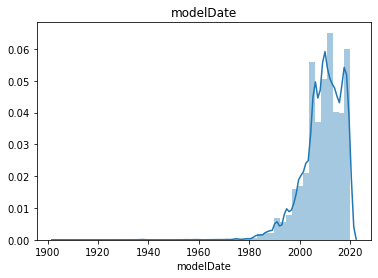

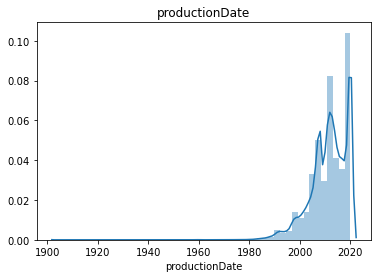

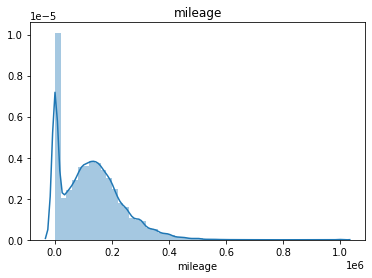

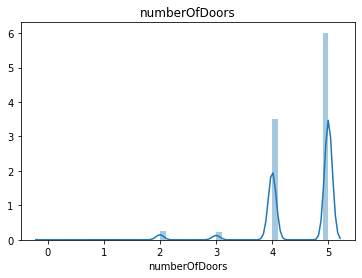

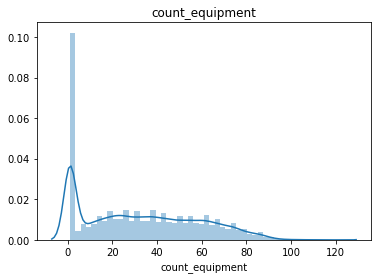

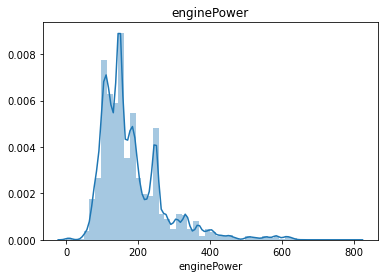

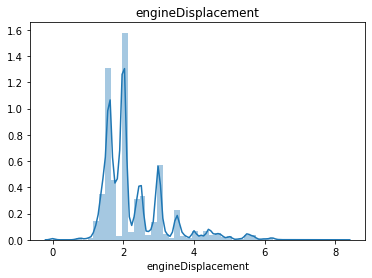

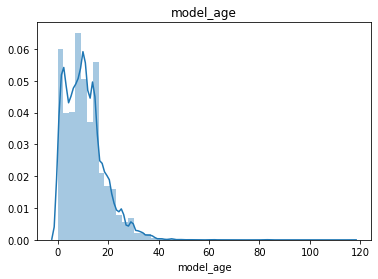

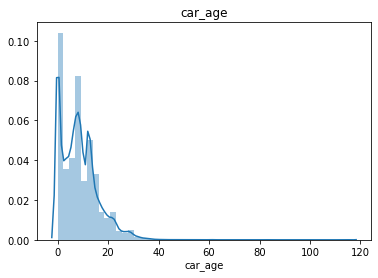

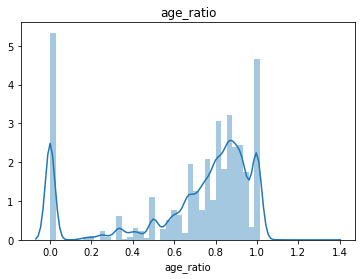

In [199]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i])
    plt.title(i)
    plt.show()

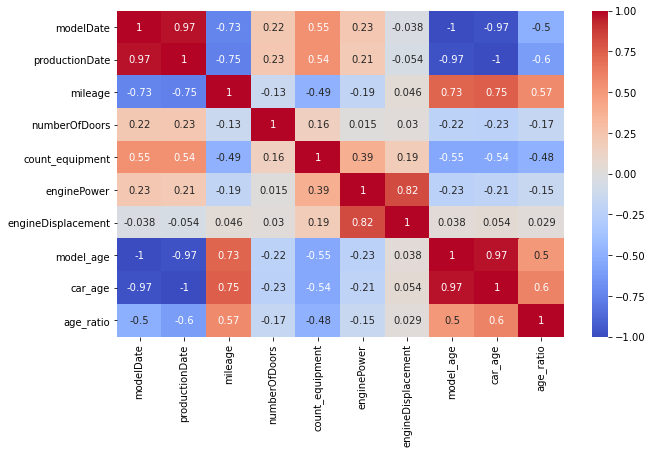

In [200]:
# Посмотрим корреляцию числовых признаков
correlation = df[num_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Из графика видно:
+0.97 между годом выпуска и годом модели и новыми признаками. Для анализа оставим car age
-0.75 между пробегом и годом производства. Год производства удалим

In [201]:
for col in cat_cols:
    print(col, df[col].nunique(), '\n', df[col].value_counts()[:6], '\n')

bodyType 25 
 внедорожник 5 дв.    44171
седан                36493
хэтчбек 5 дв.         9205
лифтбек               5358
универсал 5 дв.       3950
минивэн               3172
Name: bodyType, dtype: int64 

brand 36 
 MERCEDES      15033
BMW           10419
VOLKSWAGEN     9968
NISSAN         8980
AUDI           7102
TOYOTA         6972
Name: brand, dtype: int64 

color 16 
 чёрный         31905
белый          20096
серый          13881
серебристый    12522
синий          11443
красный         5618
Name: color, dtype: int64 

fuelType 5 
 бензин     90499
дизель     19442
гибрид       449
электро      162
газ           22
Name: fuelType, dtype: int64 

model_name 1467 
 E-Класс    1825
Focus      1636
X5         1467
A6         1452
OCTAVIA    1418
Polo       1350
Name: model_name, dtype: int64 

vehicleTransmission 4 
 автоматическая      62061
механическая        27029
роботизированная    11604
вариатор             9880
Name: vehicleTransmission, dtype: int64 

vendor 6 
 EUROPEAN    

In [202]:
df.sample()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,20-inch-wheels,folding-front-passenger-seat,traffic-sign-recognition,turnbuckle,power-latching-doors,roller-blinds-for-rear-side-windows,vsm,programmed-block-heater,seats-5,wheel-memory
5815,седан,BMW,чёрный,дизель,2016.0,520d xDrive 2.0d AT (190 л.с.) 4WD,4.0,2018,SEDAN AUTOMATIC 520d,автоматическая,...,0,0,0,0,0,0,0,0,0,0


## Data Preprocessing

In [203]:
columns=['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'modelDate',
       'mileage', 'numberOfDoors', 'vehicleTransmission', 'vendor', 'model_name', 'Таможня',
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'month_ownership', 'car_age', 'age_ratio','Train', 'count_equipment'] + equipment_cols

In [204]:
df_cars = df[columns]

## Label Encoding

In [205]:
data = df_cars

In [206]:
for colum in cat_cols:
    data[colum] = data[colum].astype('category').cat.codes

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Значимость переменных (на основе однофакторного дисперсионного анализа (ANOVA))

Для оценки значимости переменных будем использовать функцию **mutual_info_regression** из библиотеки **sklearn**.

В качестве меры значимости мы будем использовать значение  ***f*** -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

In [207]:
# Определим значимость признаков
imp_cat = pd.DataFrame(mutual_info_regression(data[data['Train']==1], df[df['Train']==1]['price'],
                                     discrete_features= True), index = data.columns)
imp_cat.sort_values(by=0, ascending=False, inplace = True)
imp_cat[0] = imp_cat[0].round(decimals=2)

In [208]:
importance_attributes = imp_cat.copy()
# collinear_data = fs.record_collinear.copy()
data_main = data.copy()
lst_del_feature = []

# while len(collinear_data)>0:
#     drop_feature = collinear_data.loc[collinear_data.index[0], 'drop_feature']
#     corr_feature = collinear_data.loc[collinear_data.index[0], 'corr_feature']
# #     print(drop_feature, corr_feature)
#     importance_drop_feature = importance_attributes.loc[drop_feature, 0]
#     importance_corr_feature = importance_attributes.loc[corr_feature, 0]
#     if importance_drop_feature >= importance_corr_feature:
#         del_feature = corr_feature
#     else:
#         del_feature = drop_feature
# #     print(drop_feature, importance_drop_feature, corr_feature, importance_corr_feature, del_feature)
#     collinear_data.drop(collinear_data[(collinear_data['drop_feature']==del_feature)|
#                                        (collinear_data['corr_feature']==del_feature)].index, axis=0, inplace=True)
#     if del_feature!='Train':
#         lst_del_feature.append(del_feature)

# определим список признаков со значимостью менее 0.25
min_importance = 0.25 # минимальная важность признака
while len(importance_attributes[importance_attributes[0]<min_importance]>0):
    del_feature = importance_attributes[importance_attributes[0]<min_importance].index[0]
#     print (del_feature, importance_attributes.loc[del_feature][0])
    importance_attributes.drop(importance_attributes[importance_attributes.index==del_feature].index, axis=0, inplace=True)
    if del_feature!='Train':
        lst_del_feature.append(del_feature)
        
print(len(lst_del_feature), lst_del_feature)

134 ['keyless-entry', 'isofix', 'android-auto', 'wheel-leather', 'auto-park', 'auto-mirrors', 'passenger-seat-electric', 'esp', 'airbag-side', 'paint-metallic', 'asr', 'collision-prevention-assist', 'vendor', 'third-rear-headrest', 'servo', 'navigation', 'heated-wash-system', 'body-kit', 'front-centre-armrest', 'rear-camera', 'drive-mode-sys', 'leather', 'computer', 'usb', 'automatic-lighting-control', 'cruise-control', '12v-socket', 'decorative-interior-lighting', 'black-roof', 'front-seats-heat', 'voice-recognition', 'music-super', 'high-beam-assist', 'mirrors-heat', 'seat-transformation', 'wheel-configuration2', 'electro-window-back', 'adaptive-light', 'color', 'door-sill-panel', 'steering-wheel-gear-shift-paddles', 'airbag-passenger', 'drl', 'volume-sensor', 'start-stop-function', 'seat-memory', 'immo', 'climate-control-2', 'park-assist-f', 'airbag-driver', 'electro-mirrors', '360-camera', 'electronic-gage-panel', 'fabric-seats', 'knee-airbag', 'abs', 'aux', 'roof-rails', 'park-ass

In [209]:
data1 = data.copy()
# удалим признаки с малой значимостью
data1.drop(lst_del_feature, axis=1, inplace=True)
data1

,bodyType,brand,engineDisplacement,enginePower,modelDate,mileage,vehicleTransmission,model_name,Владельцы,Привод,...,airbag-curtain,tyre-pressure,hcc,start-button,wheel-heat,led-lights,bas,electro-trunk,glonass,apple-carplay
0,16,0,2.3,133,1990.0,172772,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0
1,16,0,2.3,133,1990.0,10000,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
2,16,0,2.3,136,1988.0,330000,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
3,16,0,2.0,112,1982.0,500000,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0
4,16,0,2.0,115,1988.0,150000,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110569,16,1,1.6,136,2011.0,115000,0,58,2,0,...,1,0,1,1,1,0,0,0,0,0
110570,16,1,2.0,190,2016.0,98000,0,75,0,2,...,0,0,0,0,0,0,0,0,0,0
110571,16,1,2.5,170,1995.0,360000,0,75,2,0,...,0,0,0,0,0,0,0,0,0,0
110572,1,1,2.0,184,2012.0,90500,0,1400,1,2,...,1,0,0,1,1,0,0,0,0,0


In [210]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110574 entries, 0 to 110573
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             110574 non-null  int8   
 1   brand                110574 non-null  int8   
 2   engineDisplacement   110574 non-null  float64
 3   enginePower          110574 non-null  int64  
 4   modelDate            110574 non-null  float64
 5   mileage              110574 non-null  int64  
 6   vehicleTransmission  110574 non-null  int8   
 7   model_name           110574 non-null  int16  
 8   Владельцы            110574 non-null  int8   
 9   Привод               110574 non-null  int8   
 10  car_age              110574 non-null  int64  
 11  age_ratio            110574 non-null  float64
 12  Train                110574 non-null  int64  
 13  count_equipment      110574 non-null  int64  
 14  multi-wheel          110574 non-null  uint8  
 15  bluetooth        

In [211]:
data1.drop(['car_age'], axis=1, inplace=True)

In [212]:
X = data1.query('Train == 1').drop(['Train'], axis=1)
X_sub = data1.query('Train == 0').drop(['Train'], axis=1)
y = df['price'][df['Train'] == 1]

In [213]:
X

,bodyType,brand,engineDisplacement,enginePower,modelDate,mileage,vehicleTransmission,model_name,Владельцы,Привод,...,airbag-curtain,tyre-pressure,hcc,start-button,wheel-heat,led-lights,bas,electro-trunk,glonass,apple-carplay
0,16,0,2.3,133,1990.0,172772,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0
1,16,0,2.3,133,1990.0,10000,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
2,16,0,2.3,136,1988.0,330000,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
3,16,0,2.0,112,1982.0,500000,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0
4,16,0,2.0,115,1988.0,150000,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75883,12,30,2.0,149,2013.0,171000,0,1225,0,2,...,0,0,0,0,0,0,0,0,0,0
75884,12,30,2.0,149,2013.0,186000,0,1225,0,2,...,0,0,0,1,1,0,0,0,0,0
75885,12,30,2.0,149,2013.0,120000,0,1225,2,2,...,0,0,0,0,1,0,0,0,0,0
75886,12,30,2.0,149,2013.0,190487,0,1225,2,2,...,0,0,0,0,0,0,0,0,0,0


In [214]:
y

0         100000.0
1         190000.0
2          65000.0
3          55000.0
4          90000.0
           ...    
75883    1000000.0
75884    1170000.0
75885    1300000.0
75886    1015000.0
75887    1280000.0
Name: price, Length: 75888, dtype: float64

In [215]:
X_sub

,bodyType,brand,engineDisplacement,enginePower,modelDate,mileage,vehicleTransmission,model_name,Владельцы,Привод,...,airbag-curtain,tyre-pressure,hcc,start-button,wheel-heat,led-lights,bas,electro-trunk,glonass,apple-carplay
75888,8,29,1.2,105,2013.0,74000,3,904,2,1,...,0,0,0,0,0,0,0,0,0,0
75889,8,29,1.6,110,2017.0,60563,2,904,0,1,...,0,1,0,0,1,0,0,0,0,0
75890,8,29,1.8,152,2013.0,88000,3,1157,0,1,...,1,1,1,0,0,0,0,0,0,0
75891,8,29,1.6,110,2013.0,95000,0,904,0,1,...,0,1,1,0,0,0,0,0,0,0
75892,8,29,1.8,152,2008.0,58536,0,904,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110569,16,1,1.6,136,2011.0,115000,0,58,2,0,...,1,0,1,1,1,0,0,0,0,0
110570,16,1,2.0,190,2016.0,98000,0,75,0,2,...,0,0,0,0,0,0,0,0,0,0
110571,16,1,2.5,170,1995.0,360000,0,75,2,0,...,0,0,0,0,0,0,0,0,0,0
110572,1,1,2.0,184,2012.0,90500,0,1400,1,2,...,1,0,0,1,1,0,0,0,0,0


## Train Split

In [216]:
VAL_SIZE

0.2

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

In [218]:
X1 = data1.query('Train == 1').drop(['Train'], axis=1)
X1_sub = data1.query('Train == 0').drop(['Train'], axis=1)

In [219]:
X1

,bodyType,brand,engineDisplacement,enginePower,modelDate,mileage,vehicleTransmission,model_name,Владельцы,Привод,...,airbag-curtain,tyre-pressure,hcc,start-button,wheel-heat,led-lights,bas,electro-trunk,glonass,apple-carplay
0,16,0,2.3,133,1990.0,172772,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0
1,16,0,2.3,133,1990.0,10000,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
2,16,0,2.3,136,1988.0,330000,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
3,16,0,2.0,112,1982.0,500000,2,3,1,1,...,0,0,0,0,0,0,0,0,0,0
4,16,0,2.0,115,1988.0,150000,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75883,12,30,2.0,149,2013.0,171000,0,1225,0,2,...,0,0,0,0,0,0,0,0,0,0
75884,12,30,2.0,149,2013.0,186000,0,1225,0,2,...,0,0,0,1,1,0,0,0,0,0
75885,12,30,2.0,149,2013.0,120000,0,1225,2,2,...,0,0,0,0,1,0,0,0,0,0
75886,12,30,2.0,149,2013.0,190487,0,1225,2,2,...,0,0,0,0,0,0,0,0,0,0


In [220]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## Fit

In [221]:
# CATBOOST
ITERATIONS = 6000
LR         = 0.1

In [222]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          loss_function='RMSE',
                          eval_metric='MAPE',# MAPE
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.5705412	test: 2.5146161	best: 2.5146161 (0)	total: 68.8ms	remaining: 6m 52s
100:	learn: 0.2518308	test: 0.2506924	best: 0.2506924 (100)	total: 1.65s	remaining: 1m 36s
200:	learn: 0.2086976	test: 0.2106352	best: 0.2106352 (200)	total: 3.29s	remaining: 1m 35s
300:	learn: 0.1845122	test: 0.1882977	best: 0.1882977 (300)	total: 4.79s	remaining: 1m 30s
400:	learn: 0.1702666	test: 0.1753771	best: 0.1753771 (400)	total: 6.34s	remaining: 1m 28s
500:	learn: 0.1618326	test: 0.1677920	best: 0.1677920 (500)	total: 7.97s	remaining: 1m 27s
600:	learn: 0.1553436	test: 0.1621790	best: 0.1621790 (600)	total: 9.59s	remaining: 1m 26s
700:	learn: 0.1502755	test: 0.1577357	best: 0.1577357 (700)	total: 11.1s	remaining: 1m 23s
800:	learn: 0.1468883	test: 0.1548380	best: 0.1548380 (800)	total: 12.7s	remaining: 1m 22s
900:	learn: 0.1432454	test: 0.1522057	best: 0.1522057 (900)	total: 14.5s	remaining: 1m 21s
1000:	learn: 0.1399254	test: 0.1495404	best: 0.1495404 (1000)	total: 16.1s	remaining: 1m 20s


In [223]:
model.save_model('catboost_single_model_baseline.model')

In [224]:
predict = model.predict(X_test)

# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 12.58%


# Random Forest

In [225]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)
test_predict = rf.predict(X_test)
print(f"Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")

Test MAPE: 13.334%


In [226]:
rf2 = RandomForestRegressor(n_estimators=250, min_samples_split=2, min_samples_leaf=1, 
                          max_features='sqrt',max_depth=55, bootstrap=True, random_state=42)
rf2.fit(X_train, y_train)
test_predict = rf2.predict(X_test)
print(f"Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")

Test MAPE: 14.414%


# Bagging

In [227]:
tree = DecisionTreeRegressor(max_features=int(X_train.shape[1]/3), max_depth=50)
tree.fit(X_train, y_train)
test_predict = tree.predict(X_test)
print(f"DecisionTreeRegressor Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")

DecisionTreeRegressor Test MAPE: 17.214%


In [228]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# GradientBoosting

In [229]:
gb = GradientBoostingRegressor(max_depth=7,n_estimators=1000,learning_rate=0.1,random_state=42)
gb.fit(X_train, y_train)
test_predict = gb.predict(X_test)
print(f"GradientBoostingRegressor Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")

GradientBoostingRegressor Test MAPE: 12.471%


## GridSearch

In [230]:
hyperparameters = [
    {'n_estimators': [200, 250], 
     'max_depth':[50,90]},
]

model = RandomForestRegressor(random_state=RANDOM_SEED)

# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [50, 90], 'n_estimators': [200, 250]}],
             scoring='neg_mean_squared_error')

In [231]:
model_gridsearch = gridsearch.best_estimator_

# Печатаем параметры
best_parameters = model_gridsearch.get_params()
print(f'Лучшие значения параметров:') 
for param_name in sorted(best_parameters.keys()):
        print(f'  {param_name} => {best_parameters[param_name]}')

Лучшие значения параметров:
  bootstrap => True
  ccp_alpha => 0.0
  criterion => mse
  max_depth => 50
  max_features => auto
  max_leaf_nodes => None
  max_samples => None
  min_impurity_decrease => 0.0
  min_impurity_split => None
  min_samples_leaf => 1
  min_samples_split => 2
  min_weight_fraction_leaf => 0.0
  n_estimators => 250
  n_jobs => None
  oob_score => False
  random_state => 42
  verbose => 0
  warm_start => False


In [232]:
test_predict = gridsearch.predict(X_test)
print(f"DecisionTreeRegressor Test MAPE: {mape(y_test, test_predict)*100:0.3f}%")

DecisionTreeRegressor Test MAPE: 13.202%


# Stacking

In [233]:
test = data1.query('Train == 0').drop(['Train'], axis=1)
train = data1.query('Train == 1').drop(['Train'], axis=1)

In [234]:

X = train.values
y = y.values
X_pred = test.values

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [236]:
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
models = [RandomForestRegressor(n_estimators =250,random_state = RANDOM_SEED, n_jobs = -1, verbose = 1), 
          BaggingRegressor(ExtraTreesRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED), 
          RandomForestRegressor(random_state=42)]

def stacking_model_predict(models, X, y, test_data, sample_submission):
    for model_ in tqdm(models):
        model_.fit(X, y)
        pred_subm = model_.predict(test_data)
        sample_submission[str(model_)[:6]] = pred_subm
    sample_submission['price'] = sample_submission.iloc[:,2:].mean(axis=1)
    sample_submission[['sell_id', 'price']].to_csv(f'submission_v_stack{26}.csv', index=False)
    sample_submission.head(10)

stacking_model_predict(models, X, y, test, sample_submission)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   49.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.9s finished


# Submission

In [237]:
predict_submission = gridsearch.predict(X1_sub)
predict_submission

array([ 647263.992, 1006774.68 ,  901320.076, ...,  270440.   ,
       1157846.396, 1113044.   ])

In [239]:
sample_submission['price'] = predict_submission
sample_submission[['sell_id', 'price']].to_csv(f'submission_grid_v{27}.csv', index=False)
sample_submission.head(10)

,sell_id,price,Random,Baggin
0,1100575026,6.472640e+05,609300.00,6.637414e+05
1,1100549428,1.006775e+06,996900.00,9.991715e+05
2,1100658222,9.013201e+05,847958.60,9.591473e+05
3,1100937408,8.870832e+05,848769.98,8.462988e+05
4,1101037972,8.941071e+05,883437.90,7.878104e+05
5,1100912634,7.429636e+05,748790.00,7.567239e+05
6,1101228730,6.788080e+05,681210.00,7.263829e+05
7,1100165896,4.901800e+05,441290.00,4.334270e+05
8,1100768262,1.957013e+06,1886082.01,1.911255e+06
9,1101218501,9.074464e+05,884645.03,9.390931e+05
